In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas_ta as ta


In [2]:
ticker_symbol = 'HAL.NS'  # Yahoo! Finance HAL is "HAL.NS" for NSE India
stock = yf.Ticker(ticker_symbol)


In [3]:
info = stock.info

metrics = {
    "Market Cap (₹ Cr)": info.get('marketCap'),
    "Current Price (₹)": info.get('regularMarketPrice'),
    "High / Low": f"{info.get('fiftyTwoWeekHigh')}/{info.get('fiftyTwoWeekLow')}",
    "Stock P/E": info.get('trailingPE'),
    "Book Value (₹)": info.get('bookValue'),
    "Dividend Yield (%)": info.get('dividendYield', 0) * 100 if info.get('dividendYield') else None,
    "ROCE (%)": info.get('returnOnAssets', None) and round(info.get('returnOnAssets', 0) * 100, 1),
    "ROE (%)": info.get('returnOnEquity', None) and round(info.get('returnOnEquity', 0) * 100, 1),
    "Face Value (₹)": info.get('faceValue')
}
print(pd.DataFrame(metrics, index=[0]).T)


                                 0
Market Cap (₹ Cr)    3352168759296
Current Price (₹)           4651.7
High / Low          5165.0/3046.05
Stock P/E                37.174942
Book Value (₹)             523.054
Dividend Yield (%)            82.0
ROCE (%)                       4.7
ROE (%)                       26.1
Face Value (₹)                None


In [6]:
info.columns

AttributeError: 'dict' object has no attribute 'columns'

In [7]:
pros = []
cons = []

# Pros
if info.get('totalDebt', 0) < 1e7:
    pros.append("Company is almost debt free.")
if info.get('profitMargins', 0) > 0.20:
    pros.append("Good profit margins over recent years.")
if info.get('fiveYearAvgDividendYield', 0) > 0.02:
    pros.append("Robust dividend payout history.")
if info.get('returnOnEquity', 0) > 0.20:
    pros.append("High return on equity track record.")

# Cons
if metrics['Stock P/E'] and metrics['Book Value (₹)'] and metrics['Book Value (₹)'] > 0:
    pb = info['regularMarketPrice'] / metrics['Book Value (₹)']
    if pb > 5:
        cons.append("Stock is trading at high P/B value.")
if info.get('revenueGrowth', 0) < 0.1:
    cons.append("Poor sales growth in recent years.")
# if info.get('trailingPegRatio', 0) > 2:
#     cons.append("Stock price high relative to earnings growth.")

print("PROS:")
for p in pros: print("-", p)
print("\nCONS:")
for c in cons: print("-", c)


PROS:
- Good profit margins over recent years.
- Robust dividend payout history.
- High return on equity track record.

CONS:
- Stock is trading at high P/B value.
- Poor sales growth in recent years.


In [8]:
fin = stock.financials.T
bal = stock.balance_sheet.T
cf = stock.cashflow.T

print("Income statement columns:", fin.columns.tolist())
print("Balance sheet columns:", bal.columns.tolist())
print("Cash flow statement columns:", cf.columns.tolist())


Income statement columns: ['Tax Effect Of Unusual Items', 'Tax Rate For Calcs', 'Normalized EBITDA', 'Total Unusual Items', 'Total Unusual Items Excluding Goodwill', 'Net Income From Continuing Operation Net Minority Interest', 'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA', 'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income', 'Normalized Income', 'Net Income From Continuing And Discontinued Operation', 'Total Expenses', 'Rent Expense Supplemental', 'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS', 'Basic EPS', 'Diluted NI Availto Com Stockholders', 'Net Income Common Stockholders', 'Otherunder Preferred Stock Dividend', 'Net Income', 'Minority Interests', 'Net Income Including Noncontrolling Interests', 'Net Income Discontinuous Operations', 'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income', 'Other Non Operating Income Expenses', 'Special Income Charges', 'Other Special Charges', 'Write Off', 'Impairment Of Capital 

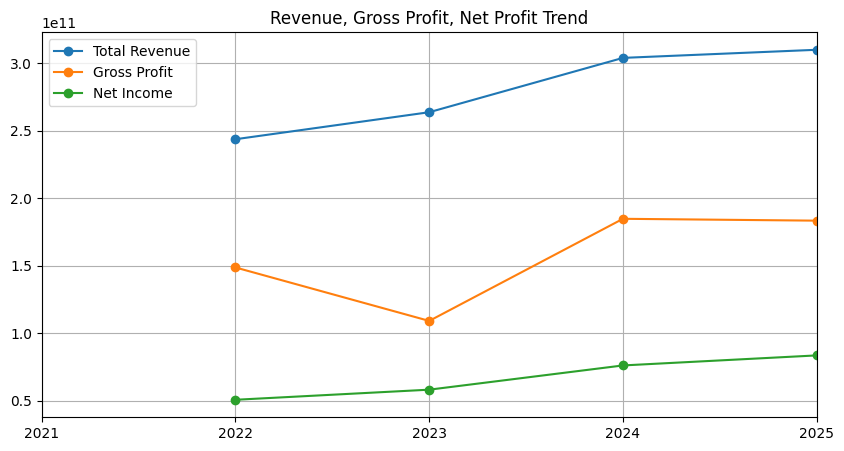

In [12]:
fin_plot = fin[['Total Revenue', 'Gross Profit', 'Net Income']].copy()
fin_plot.plot(marker='o', figsize=(10,5), title='Revenue, Gross Profit, Net Profit Trend')
plt.grid(visible=True)
plt.show()


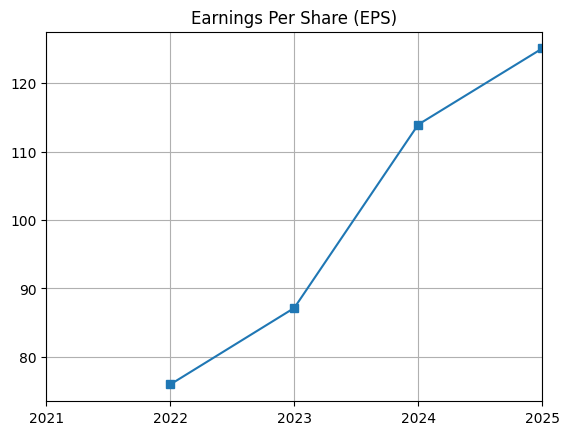

In [13]:
if 'Diluted EPS' in fin:
    plt.figure()
    fin['Diluted EPS'].plot(marker='s', title='Earnings Per Share (EPS)')
    plt.grid()
    plt.show()


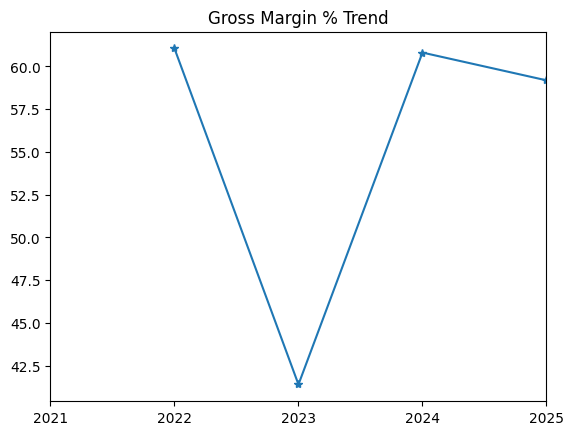

In [14]:
if 'Gross Profit' in fin and 'Total Revenue' in fin:
    fin['Gross Margin %'] = fin['Gross Profit'] / fin['Total Revenue'] * 100
    fin['Gross Margin %'].plot(marker='*', title='Gross Margin % Trend')
    plt.show()


In [15]:
# Gross and Operating Margin
if 'Gross Profit' in fin and 'Total Revenue' in fin:
    fin['Gross Margin %'] = (fin['Gross Profit'] / fin['Total Revenue']) * 100

if 'Operating Income' in fin and 'Total Revenue' in fin:
    fin['Operating Margin %'] = (fin['Operating Income'] / fin['Total Revenue']) * 100

# ROE, ROCE
roe = info.get('returnOnEquity', 0) * 100 if info.get('returnOnEquity') is not None else np.nan
roce = info.get('returnOnAssets', 0) * 100 if info.get('returnOnAssets') is not None else np.nan

print(f"ROE: {roe:.2f}%, ROCE: {roce:.2f}%")


ROE: 26.09%, ROCE: 4.70%


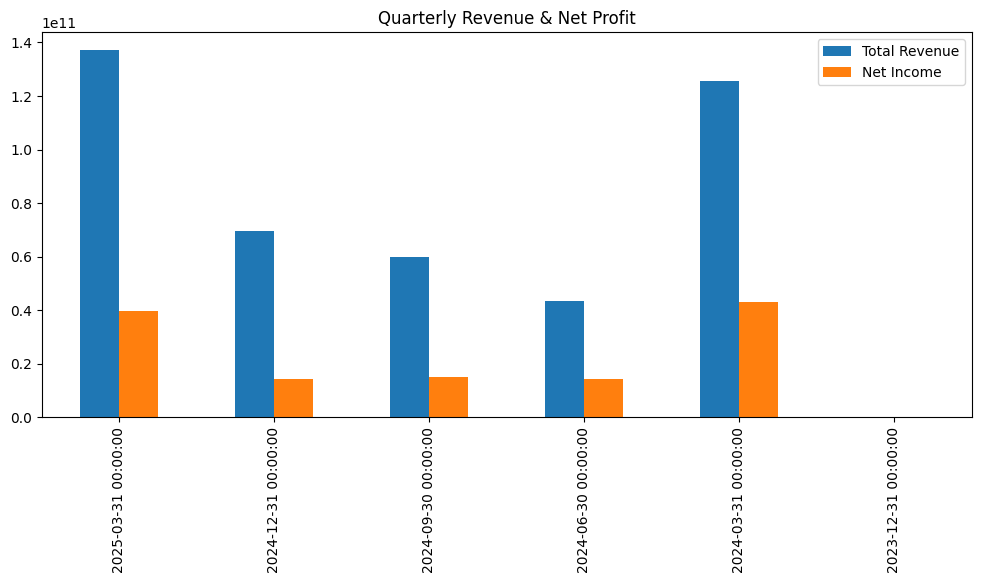

In [16]:
qtr = stock.quarterly_financials.T
if not qtr.empty:
    qtr[['Total Revenue', 'Net Income']].plot(kind='bar', figsize=(12,5), title='Quarterly Revenue & Net Profit')
    plt.show()
else:
    print("Quarterly results not available via yfinance for this stock.")


In [17]:
peers = {
    "HAL.NS": "Hindustan Aeronautics",
    "BHEL.NS": "BHEL",
    "BEL.NS":  "Bharat Electronics",
    "BDL.NS":  "Bharat Dynamics"
}

peer_stats = []
for code, name in peers.items():
    p = yf.Ticker(code)
    peer_stats.append({
        'Company': name,
        'Price': p.info.get('regularMarketPrice'),
        'Market Cap (Cr)': p.info.get('marketCap'),
        'P/E': p.info.get('trailingPE'),
        'Book Value': p.info.get('bookValue'),
        'ROE (%)': p.info.get('returnOnEquity', np.nan) * 100 if p.info.get('returnOnEquity') else np.nan,
        'Dividend Yield (%)': p.info.get('dividendYield', 0) * 100 if p.info.get('dividendYield') else np.nan
    })
df_peers = pd.DataFrame(peer_stats)
print(df_peers)


                 Company    Price  Market Cap (Cr)         P/E  Book Value  \
0  Hindustan Aeronautics  4651.70    3352168759296   37.174942     523.054   
1                   BHEL   250.50     892278472704  163.725500      71.062   
2     Bharat Electronics   394.75    3048906686464   54.373276      27.326   
3        Bharat Dynamics  1671.60     712634859520  111.143616     109.346   

     ROE (%)  Dividend Yield (%)  
0  26.086000                82.0  
1   2.172000                19.0  
2  29.296000                88.0  
3  14.378001                25.0  


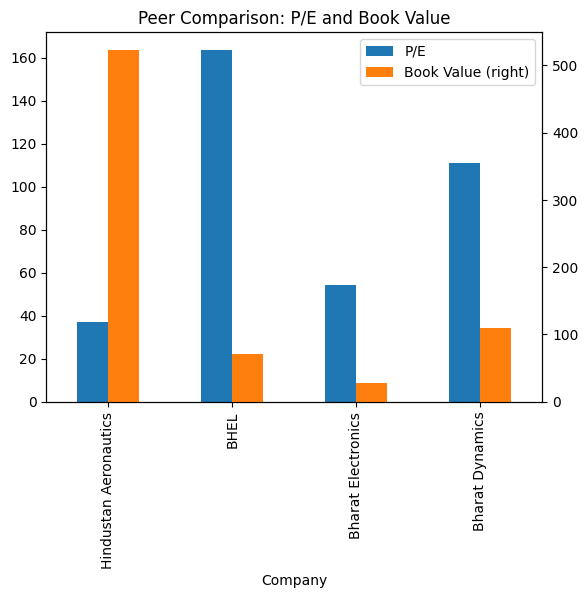

In [18]:
df_peers.plot.bar(x="Company", y=["P/E", "Book Value"], secondary_y="Book Value",
                  title='Peer Comparison: P/E and Book Value')
plt.show()


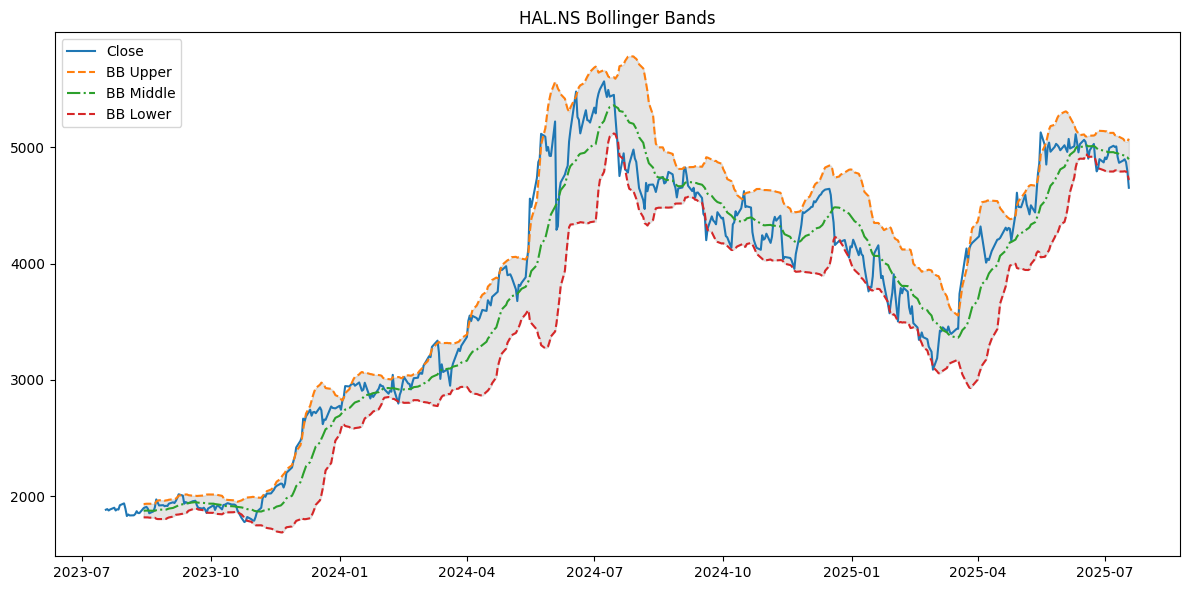

In [19]:
data_hist = stock.history(period='2y')
close = data_hist['Close']

# Bollinger Bands
bb = ta.bbands(close=close, length=20, std=2)
data_hist['BBL_20_2.0'] = bb['BBL_20_2.0']
data_hist['BBM_20_2.0'] = bb['BBM_20_2.0']
data_hist['BBU_20_2.0'] = bb['BBU_20_2.0']

plt.figure(figsize=(12,6))
plt.plot(data_hist.index, close, label='Close')
plt.plot(data_hist.index, data_hist['BBU_20_2.0'], label='BB Upper', linestyle='--')
plt.plot(data_hist.index, data_hist['BBM_20_2.0'], label='BB Middle', linestyle='-.')
plt.plot(data_hist.index, data_hist['BBL_20_2.0'], label='BB Lower', linestyle='--')
plt.fill_between(data_hist.index, data_hist['BBL_20_2.0'], data_hist['BBU_20_2.0'], color='gray', alpha=0.2)
plt.title(f"{ticker_symbol} Bollinger Bands")
plt.legend()
plt.tight_layout()
plt.show()


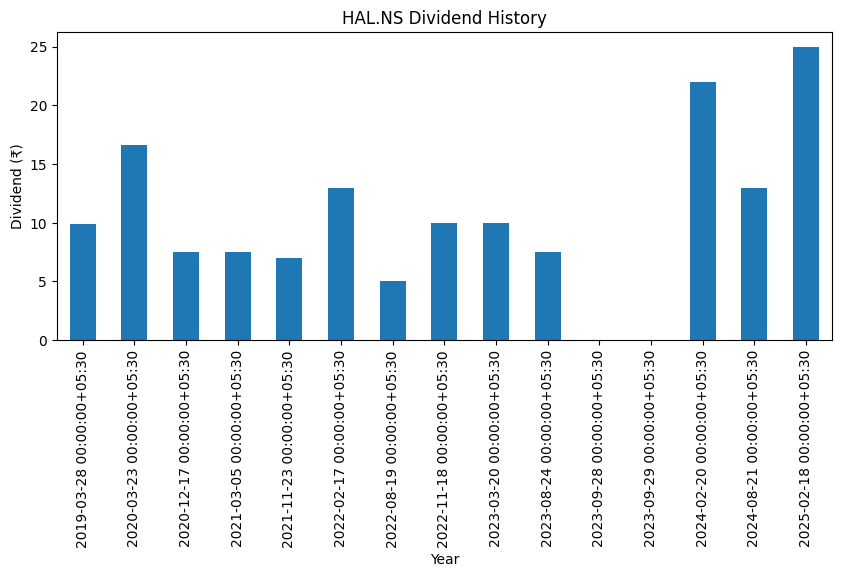

In [20]:
if 'Dividends' in stock.actions:
    dividends = stock.actions['Dividends']
    plt.figure(figsize=(10,4))
    dividends.plot.bar(title=f"{ticker_symbol} Dividend History")
    plt.ylabel("Dividend (₹)")
    plt.xlabel("Year")
    plt.show()


# GROW

In [2]:
pip install data.fetcher

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
   ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
   ----- ---------------------------------- 0.8/5.7 MB 4.8 MB/s eta 0:00:02
   ----- ---------------------------------- 0.8/5.7 MB 4.8 MB/s eta 0:00:02
   ------------ --------------------------- 1.8/5.7 MB 2.9 MB/s eta 0:00:02
   ------------------ --------------------- 2.6/5.7 MB 3.1 MB/s eta 0:00:01
   ---------------------- ----------------- 3.1/5.7 MB 2.9 MB/s eta 0:00:01
   ------------------------ --------------- 3.4/5.7 MB 3.1 MB/s eta 0:00:01
   ------------------------------- -------- 4.5/5.7 MB 3.1 MB/s eta 0:00:01
   -------------------------------------- - 5.5/5.7 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 5.7/5.7 MB 3.1 MB/s eta 0:00:00
  Created whe

  DEPRECATION: Building 'msgpack' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'msgpack'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires libclang>=13.0.0, which is not installed.
flwr 1.19.0 requires pyyaml<7.0.0,>=6.0.2, but you have pyyaml 6.0.1 which is incompatible.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 4.25.8 which is incompatible.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.10.0 which is incompa

In [3]:
from data.fetcher import DataFetcher
fetcher = DataFetcher(alpha_vantage_key="YOUR_KEY")
df_hist   = fetcher.get_stock_data("AAPL", "6mo")
info      = fetcher.get_stock_info("AAPL")
price_now = fetcher.get_real_time_price("AAPL")
news      = fetcher.get_market_news("AAPL")


ModuleNotFoundError: No module named 'data.fetcher'